# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [0]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. This loader also up/downscales the images.

In [0]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False, testing=False):
        self.testing = testing 
        self.use_gpu = use_gpu
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data.append(self.get_data_from_image(image_name))
            
#         if use_gpu:
#             for i in range(len(self.data)):
#                 self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())
                
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        image = self.data[item][0]
        
        h, w = -1, -1
        if self.testing:
            h, w = len(image), len(image[0])
        else:
            h, w = 256, 256
        
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        
        intermediate_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomCrop([cropped_h, cropped_w], pad_if_needed=True),
            ])

        input_transform = transforms.Compose([
                transforms.Resize(
                    [
                        int(cropped_h // self.upscale_factor),
                        int(cropped_w // self.upscale_factor),
                    ],
                    PIL.Image.BICUBIC,
                ),
                transforms.ToTensor(),
            ])
        
        intermediate_img = intermediate_transform(image)
        target_img = transforms.ToTensor()(intermediate_img)
        input_img = input_transform(intermediate_img)
        
        if self.use_gpu:
                input_img = input_img.cuda()
                target_img = target_img.cuda()
        
        return input_img, target_img

    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        target_image = image
        input_image = image

        return input_image, target_image

    def imshow_input(self, idx):
        img, _ = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (9 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Input image (Up-scale factor 9): 


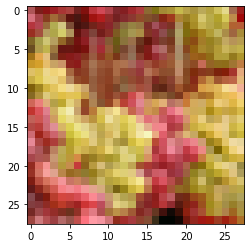

Input image (Up-scale factor 3): 


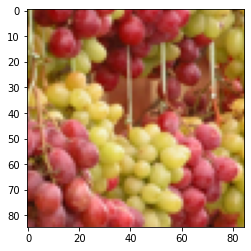

In [7]:
trainExample9 = SuperResolutionDataset("train_data/Set91", 9)
print("Input image (Up-scale factor 9): ")
trainExample9.imshow_input(0)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3)
print("Input image (Up-scale factor 3): ")
trainExample3.imshow_input(0)

Target image: 


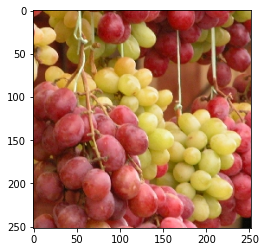

In [8]:
print("Target image: ")
trainExample9.imshow_target(0)

## Network Architecture

In [0]:
import torch.nn as nn
import torch

class SuperResolutionNet(nn.Module):
    def __init__(self, r, l=3, activation=nn.Identity()):
        super().__init__()
        self.l = l
        self.r = r

        self.activation = activation

        self.conv1 = nn.Conv2d(3, 64, 5, padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        self.deconvolution = nn.PixelShuffle(self.r)

        self.params = [self.conv1, self.conv2, self.conv3, self.conv4]

        self.l = l  # The number of hidden layers

    def forward(self, x):
        for i in range(self.l):
            x = self.activation(self.params[i](x))

        x = self.params[self.l](
            x
        )  # Don't use the activation on the last convolutional layer
        x = self.deconvolution(x)

        return x

## Training Network
Function to train a certain network with a certain data loader and hyperparameters

In [0]:
import os
import time
import math

from torch import optim

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)

def train(net, use_gpu, train_loader, r,
          learning_rate=0.001,
          max_epochs_without_improvement=100,
          max_epochs=1000,
          print_output=True,
          beta1=0.9,
          beta2=0.999):

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        if print_output:
          print('Running on gpu')

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(beta1, beta2))

    # Save computer name to use when storing network
    computer_name = "unknown"
    try:
      computer_name = os.environ['COMPUTERNAME']
    except:
      pass

    # Initialize loss.
    lowest_loss = (0, float('inf'))
    highest_psnr = - float('inf')

    begin_time = time.time()
    minimum_psnr_to_save = 20

    # Start training.
    for epoch in range(max_epochs):
        train_loss = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)

            loss = loss_function(output, target)

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        mean_psnr = mse_to_psnr(mean_train_loss)

        # Update the lowest loss if necessary.
        if mean_train_loss < lowest_loss[1]:
            #print(f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f} in {time.time() - begin_time:.2f}s #")
            lowest_loss = (epoch, mean_train_loss)
            highest_psnr = mean_psnr

            #If the psnr is above some threshold save this new best network.
            if highest_psnr > minimum_psnr_to_save:
                torch.save(net, f'SuperResulutionNet_best_of_run-{computer_name}')

        if epoch % 100 == 0 and print_output:
            print(
              f"Epoch: {epoch: >3} in {time.time() - begin_time:.2f}s, best epoch so far: Epoch: {lowest_loss[0]: >3} Training Loss: {lowest_loss[1]:.6f} Mean PSNR: {highest_psnr:.2f}")


        # If we didn't improve for some amount of epoch, lets stop.
        if epoch > lowest_loss[0] + max_epochs_without_improvement:
            if print_output:
                print(f"No improvement for the last {max_epochs_without_improvement} epochs, so stopping training...")
            break

    net.eval()
    if highest_psnr >= minimum_psnr_to_save:
        network_name = f'SuperResulutionNet_r-{r}_psnr-{int(round(highest_psnr * 100))}__mse-{int(round(lowest_loss[1] * 10000))}-{computer_name}'
        old_file = os.path.join(".", f'SuperResulutionNet_best_of_run-{computer_name}')
        new_file = os.path.join(".", network_name)
        if print_output:
            print(f'Saving best epoch ({lowest_loss[0]}) with loss: {lowest_loss[1]} and psnr: {highest_psnr} as:')
            print(network_name)
        os.rename(old_file, new_file)
    elif print_output:
        print("Not high enough psnr to save the network...")

    return lowest_loss[1]

In [22]:
use_gpu = torch.cuda.is_available()

# Batch size.
bs = 2

# Upscale factor.
r = 3

# Amount of epochs.
epochs = 20

# Getting image data
transform = transforms.Compose([transforms.ToTensor()])  # ,

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)

train_loader = torch.utils.data.DataLoader(
    training_set, batch_size=bs, shuffle=True, num_workers=0
)

# Initialize the network.
net = SuperResolutionNet(r, activation=nn.ReLU())

train(net, use_gpu, train_loader, r)

Running on gpu
Can't get computer name
Epoch:   0 in 0.40s, best epoch so far: Epoch:   0 Training Loss: 0.040299 Mean PSNR: 13.95


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 100 in 32.31s, best epoch so far: Epoch:  93 Training Loss: 0.001674 Mean PSNR: 27.76
Epoch: 200 in 64.18s, best epoch so far: Epoch: 186 Training Loss: 0.001437 Mean PSNR: 28.42
Epoch: 300 in 95.97s, best epoch so far: Epoch: 299 Training Loss: 0.001359 Mean PSNR: 28.67
Epoch: 400 in 127.50s, best epoch so far: Epoch: 367 Training Loss: 0.001313 Mean PSNR: 28.82
Epoch: 500 in 158.99s, best epoch so far: Epoch: 475 Training Loss: 0.001268 Mean PSNR: 28.97
Epoch: 600 in 190.52s, best epoch so far: Epoch: 548 Training Loss: 0.001226 Mean PSNR: 29.11
Epoch: 700 in 221.96s, best epoch so far: Epoch: 679 Training Loss: 0.001221 Mean PSNR: 29.13
Epoch: 800 in 253.50s, best epoch so far: Epoch: 790 Training Loss: 0.001198 Mean PSNR: 29.22
Epoch: 900 in 284.75s, best epoch so far: Epoch: 853 Training Loss: 0.001192 Mean PSNR: 29.24
Saving best epoch (946) with loss: 0.0011732301364131474 and psnr: 29.30616789955176 as:
SuperResulutionNet_r-3_psnr-2931__mse-12-unknown


0.0011732301364131474

## Evaluation

In [0]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

# from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_by_name(network_name):
    net = torch.load(network_name)
    evaluate(net)
    
def evaluate(network):
    r = net.r
    print(f"r: {r}")

    use_gpu = torch.cuda.is_available()

    test_set_paths = ["test_data/" + f for f in listdir("test_data")]
#     test_set_paths = ["test_data/Custom"]

    for path in test_set_paths:
        psnr = []
        test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu, testing=True)


        test_loader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)


        for input, target in iter(test_loader):
            if use_gpu:
                input = input.cuda()
                target = target.cuda()

            if input.size()[1] == 1:
                input = input.repeat(1, 3, 1, 1)

            output = net(input)


            if use_gpu:
                input = input.cpu()
                output = output.cpu()
                target = target.cpu()


            bicubic = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.BICUBIC),
                transforms.ToTensor()
            ])
            bicubic_upscaled = bicubic(input[0])

            nearest_neighbour = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.NEAREST),
                transforms.ToTensor()
            ])

            input = nearest_neighbour(input[0])
            output = torch.clamp(output.detach(), 0, 1)


            if target.size()[1] == 1:
                target = target.repeat(1, 3, 1, 1)

            mse_loss = nn.MSELoss()
            psnr.append(10 * math.log10(1. / mse_loss(output, target).item()))

            images = [input, target[0], output.detach()[0], bicubic_upscaled]

#             imshow(torchvision.utils.make_grid(images))

        print(f"{path} psnr: {np.mean(psnr)}")

    # plt.show()

In [28]:
evaluate(net)

r: 3
test_data/Set5 psnr: 30.550804275467677
test_data/Set14 psnr: 27.12847687579009


In [0]:
evaluate_by_name('SuperResulutionNet_r-3_psnr-3030__mse-10-JORIS-LAPTOP')

r: 3
test_data/BSD300 psnr: 22.764210268052036
test_data/BSD500 psnr: 22.717572154261305
test_data/Custom psnr: 23.86945576995477
test_data/Set14 psnr: 22.25212764313012
test_data/Set5 psnr: 23.606596387170093
test_data/SuperTexture psnr: 21.072878666297683


### Finding Hyperparameters

In [30]:
!pip3 install ax-platform 

     |████████████████████████████████| 501kB 8.9MB/s 
     |████████████████████████████████| 225kB 18.6MB/s 
     |████████████████████████████████| 235kB 23.4MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=93a85ac24a037851d0e2df693e98779cf5d971c5903d423d15ca192c0da322b4
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch


In [0]:
from ax import optimize

def train_evaluate(parameters):
    use_gpu = torch.cuda.is_available()
    bs = 32
    r = 3

    training_set = SuperResolutionDataset('train_data/Set91', r, use_gpu=use_gpu)
    # training_set = SuperResolutionDataset('test_data/BSD500', r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    return train(net, use_gpu, train_loader, r,
                 max_epochs=500,
                 max_epochs_without_improvement=100, 
                 learning_rate=parameters['lr'],
                 beta1=parameters['beta1'],
                 beta2=parameters['beta2'],
                 print_output=False)


best_parameters, best_values, experiment, model = optimize(
        parameters=[
            {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
            {"name": "beta1", "type": "range", "bounds": [0.5, 0.9]},
            {"name": "beta2", "type": "range", "bounds": [0.9, 0.999]},
        ],
        # Booth function
        evaluation_function=train_evaluate,
        objective_name='training-error',
        minimize=True,
    )

print(best_parameters, best_values, experiment, model)

[INFO 04-15 18:57:18] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 04-15 18:57:18] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-15 18:57:18] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-15 18:59:53] ax.service.managed_loop: Running optimization trial 2...


In [40]:
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour

render(plot_contour(model=model, param_x='lr', param_y='beta1', metric_name='training-error'))